# Instance Segmentation using Mask RCNN

## Imports

In [1]:
import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Loader

In [4]:
def load_model(model_dir):
    
    model = tf.saved_model.load(str(model_dir))
    return model

## Loading label map

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_2/data/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

We will test on a few images:

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/11.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/12.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/28.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/45.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/60.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/66.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/67.jpg'),
 PosixPath('/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/72.jpg')]

Add a wrapper function to call the model, and cleanup the outputs:

In [7]:
import itertools

def run_inference_for_single_image(model, image_np):
    
    print("Running inference for : ",image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop("num_detections"))

    detections = dict(itertools.islice(detections.items(), num_detections))

    detections["num_detections"] = num_detections

    image_np_with_detections = image_np.copy()

    # Handle models with masks:
    if "detection_masks" in detections:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              detections["detection_masks"][0], detections["detection_boxes"][0],
               image_np.shape[0], image_np.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        detections["detection_masks_reframed"] = detection_masks_reframed.numpy()

    boxes = np.asarray(detections["detection_boxes"][0])
    classes = np.asarray(detections["detection_classes"][0]).astype(np.int64)
    scores = np.asarray(detections["detection_scores"][0])
    mask = np.asarray(detections["detection_masks_reframed"])

    # Visualizing the results
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=mask,
        use_normalized_coordinates=True,
        line_thickness=3)
    
    # Display image with detections and segmented parts
    display(Image.fromarray(image_np_with_detections))

In [8]:
def show_inference(model, image_path):

    # Load image
    image_np = np.array(Image.open(image_path))
    
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)


### Load Mask RCNN model

In [10]:
model_dir = '/media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_2/inference/ExportedSavedModel/saved_model'
masking_model = load_model(model_dir)

### Perform segmentation and detection

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/11.jpg


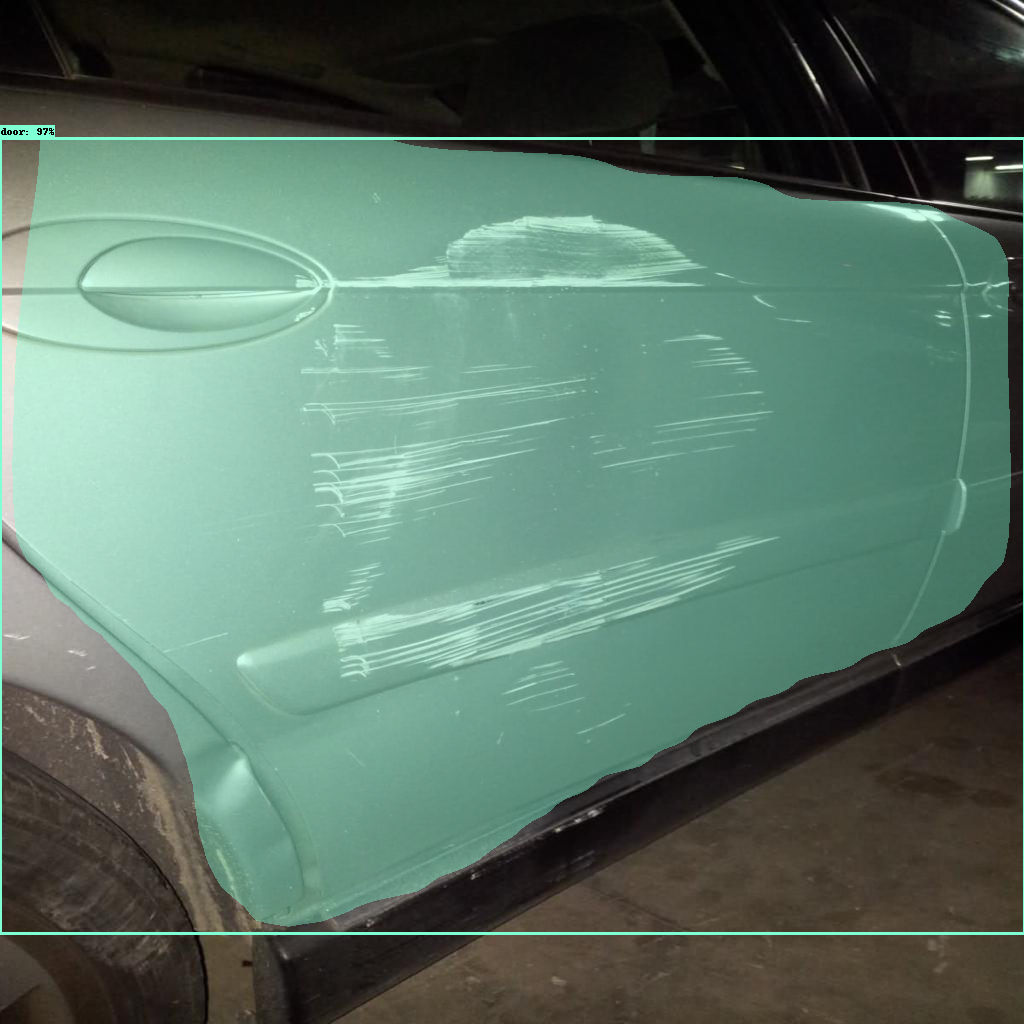

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/12.jpg


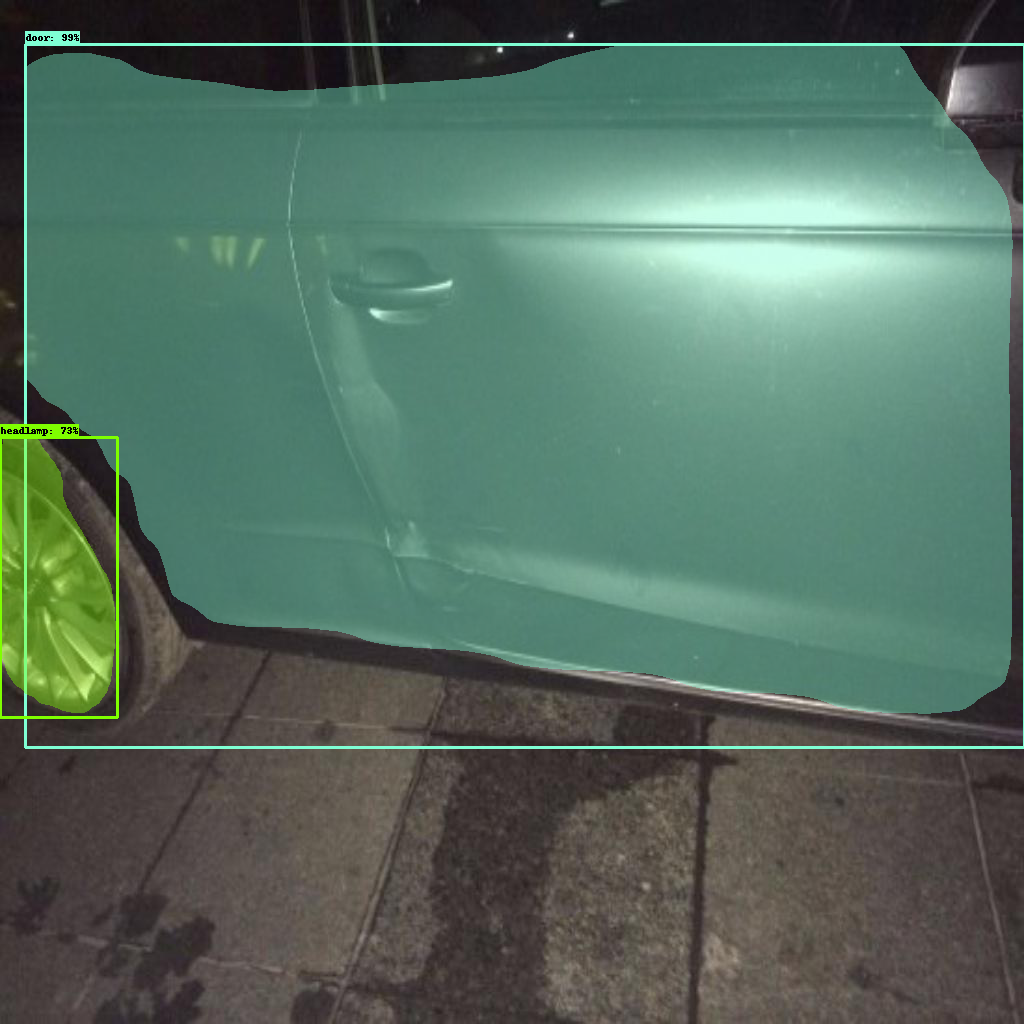

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/28.jpg


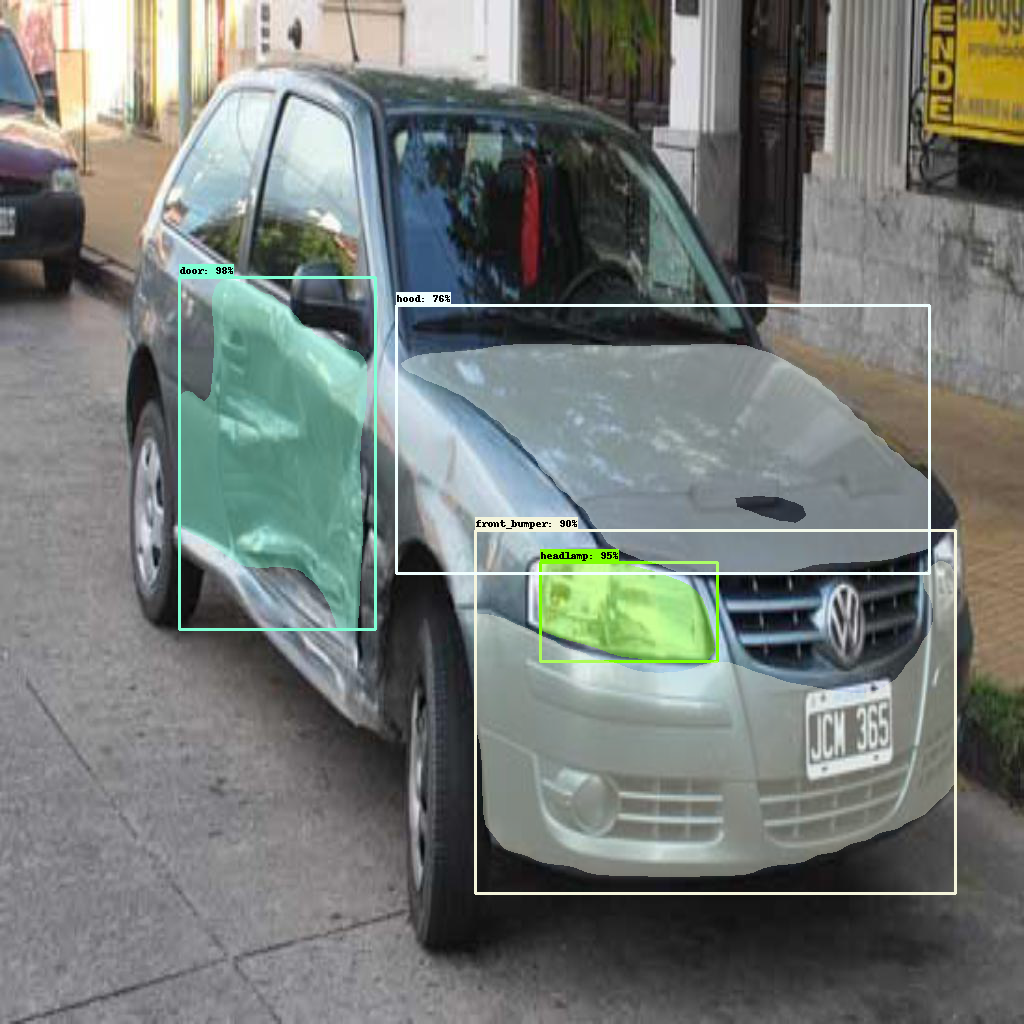

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/45.jpg


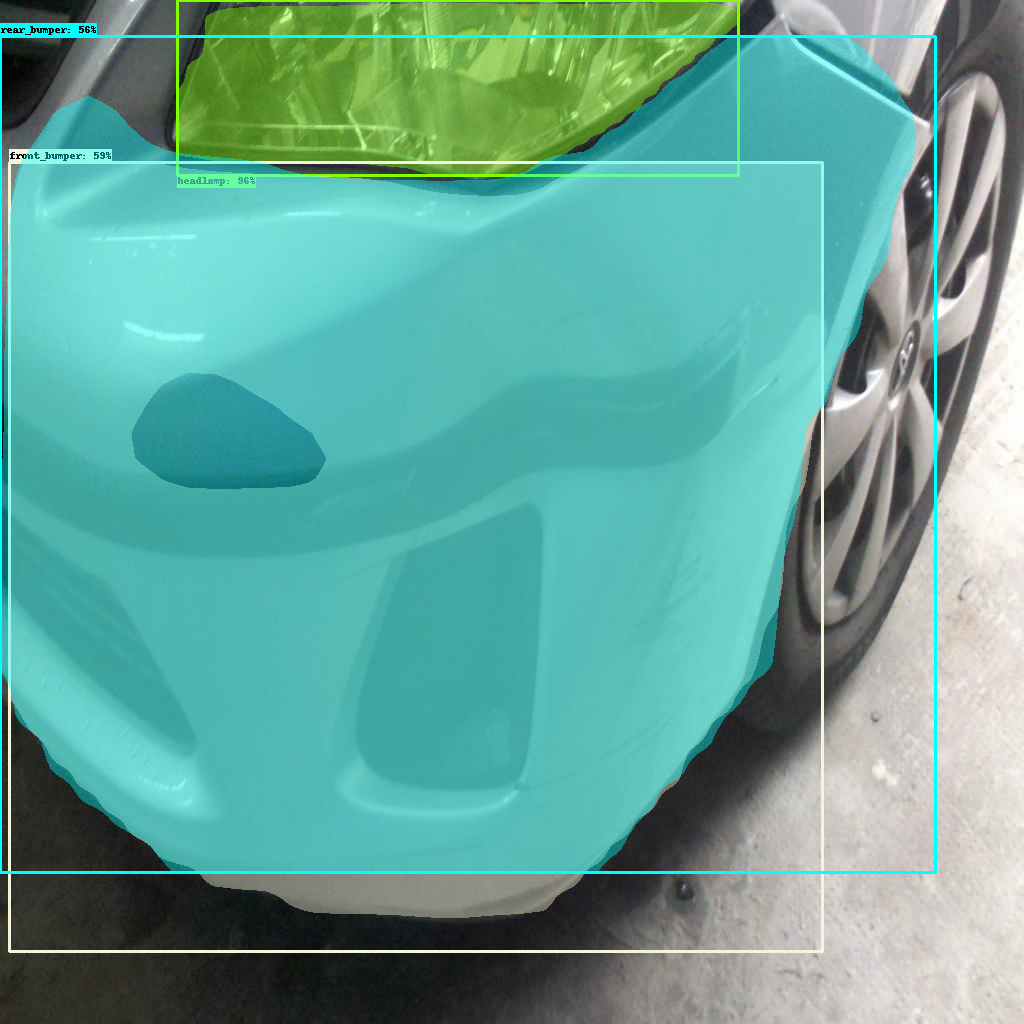

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/60.jpg


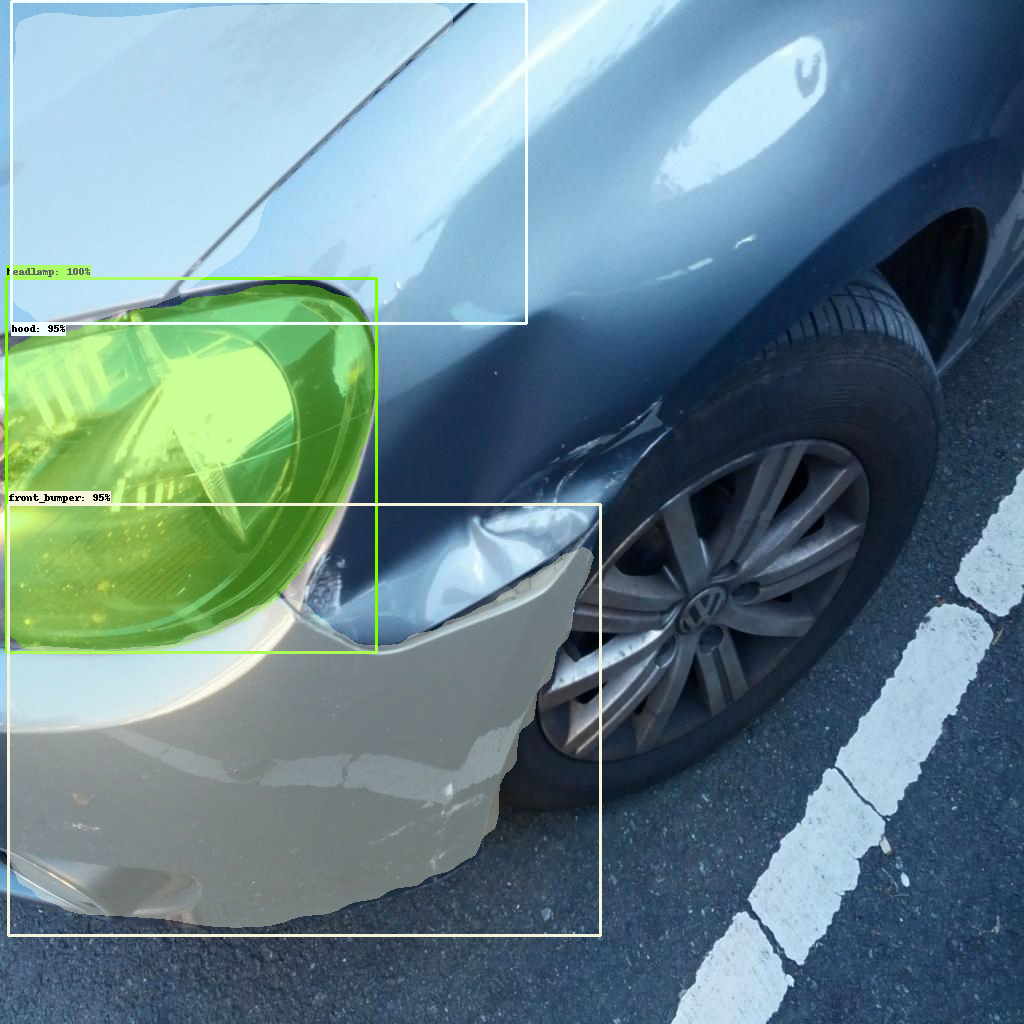

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/66.jpg


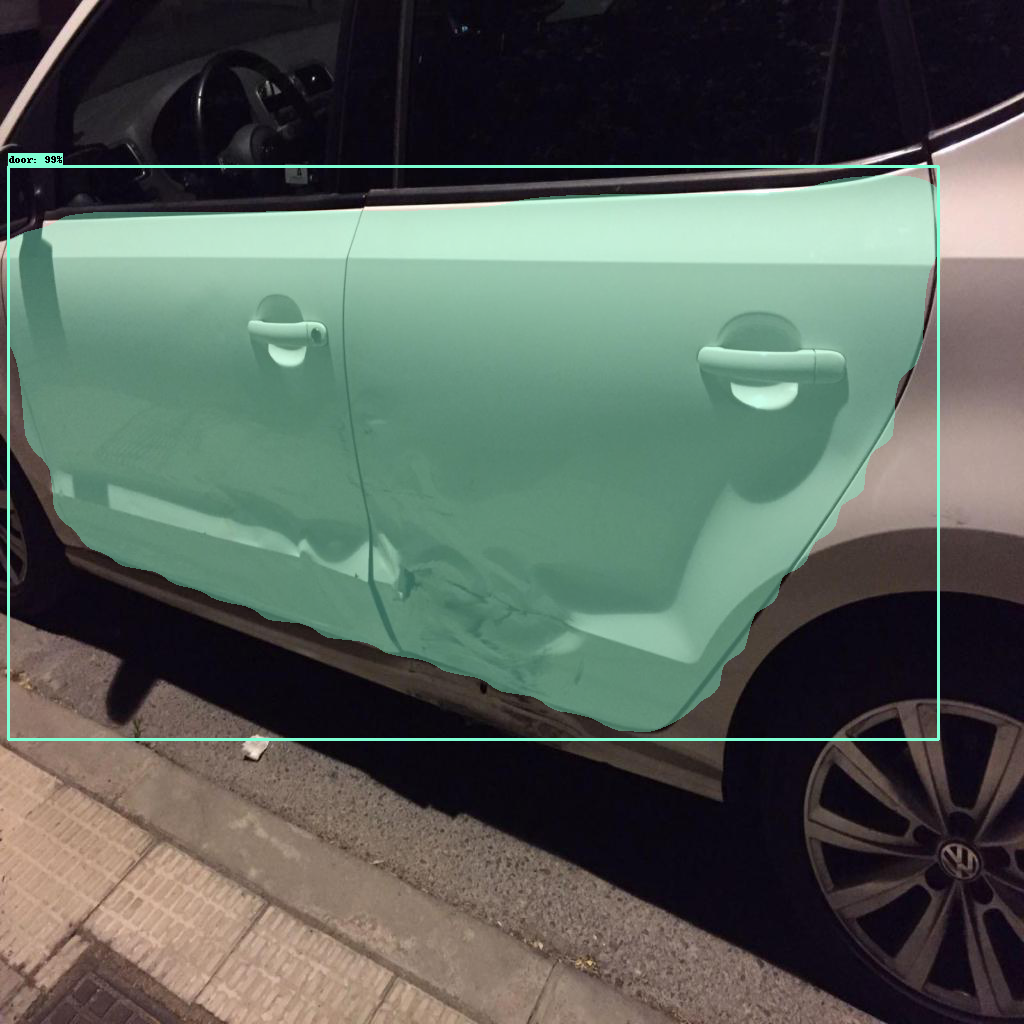

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/67.jpg


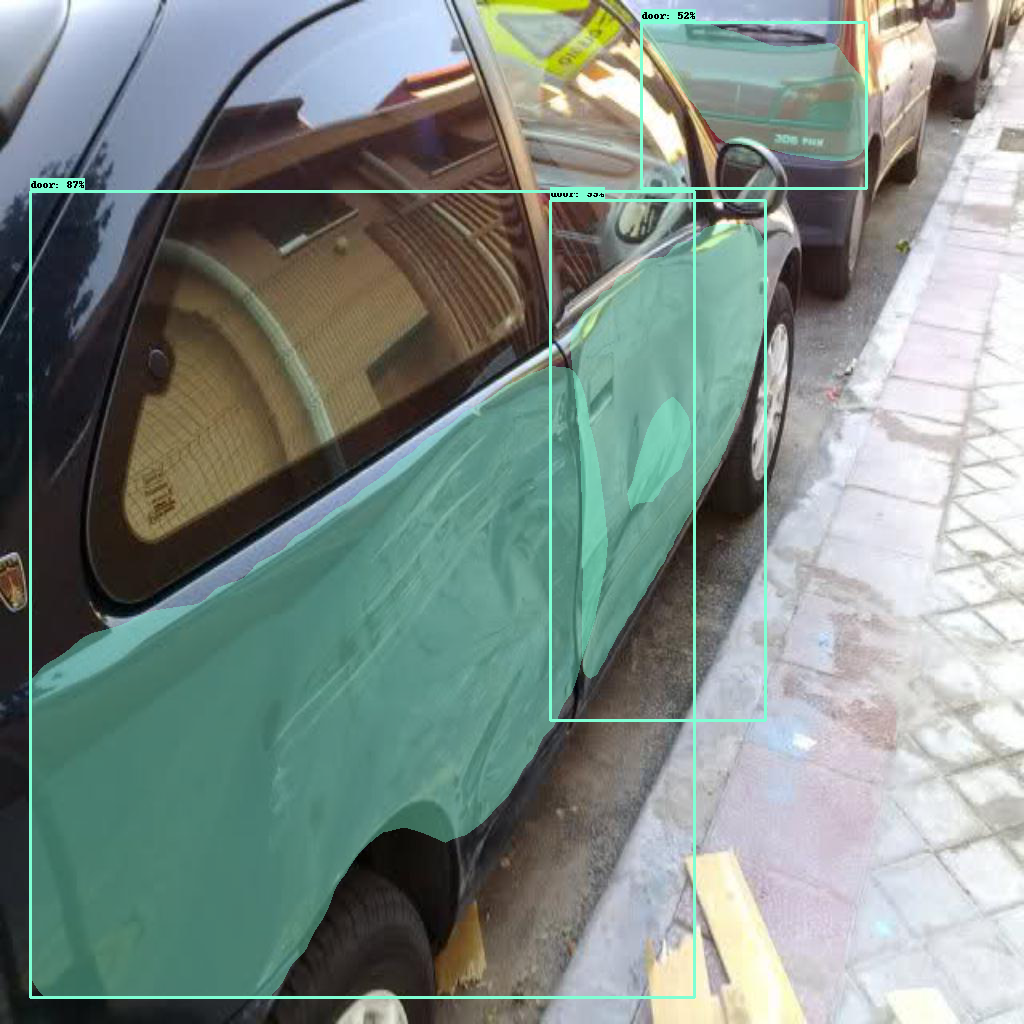

Running inference for :  /media/nourislam/Data/CodeForCourses/ImageSegmentation/Mask_RCNN/Experiment_1/data/test/72.jpg


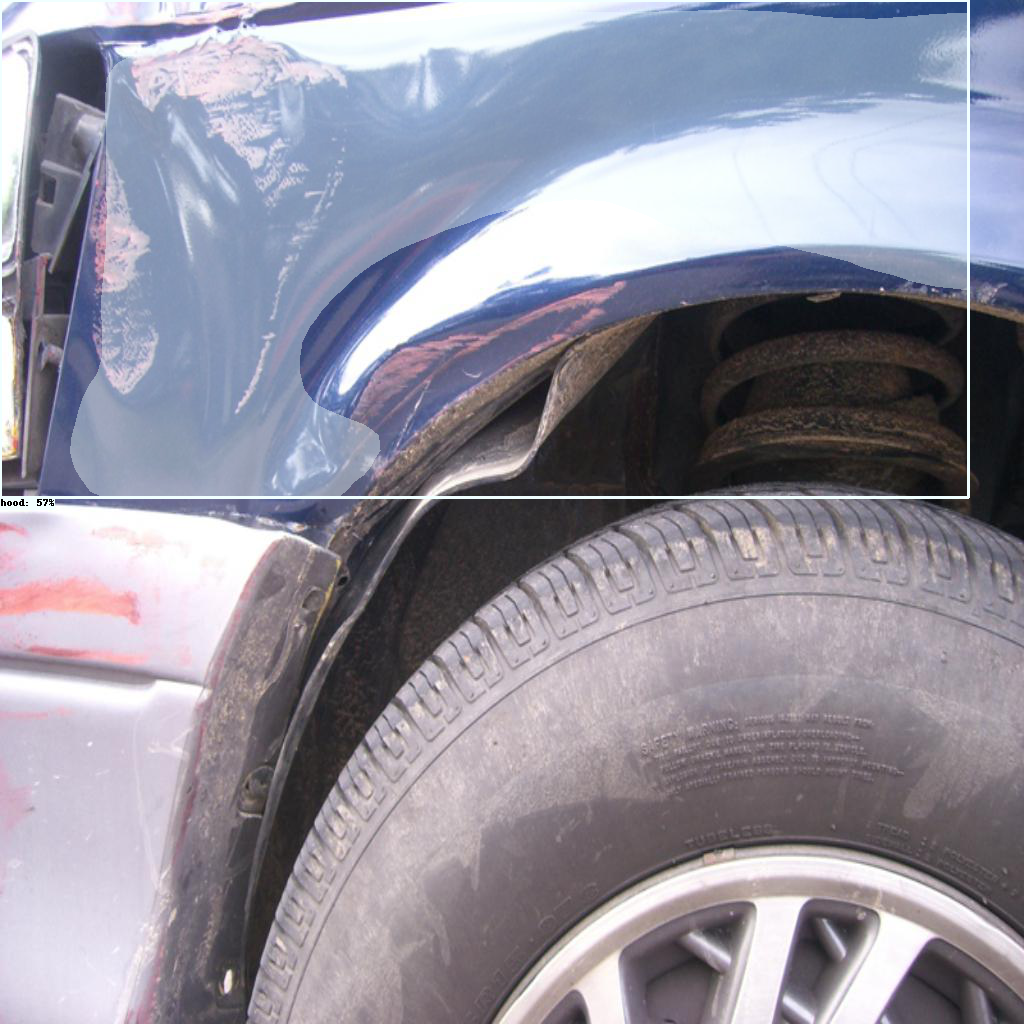

In [11]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(masking_model, image_path)